# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [ ]:
# For Colab
%tensorflow_version 2.x
!wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
!wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
!wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
!wget -q https://raw.githubusercontent.com/readmees/SpeechCmdRecognition/master/SpeechModels.py
!wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
!pip install -r requirements.txt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for kapre: filename=kapre-0.2.0-py3-none-any.whl size=12320 sha256=ba9e44e05abc5f307d7ef345035fddd3bd81957adfbc8301d13ee25a5017f51f
  Stored in directory: /root/.cache/pip/wheels/55/ea/b8/d830efb21ee5154a0f4392a8b156b5a6a553cf81593deb6145
Successfully built kapre
  Attempting uninstall: kapre
    Found existing installation: kapre 0.3.7
    Uninstalling kapre-0.3.7:
      Successfully uninstalled kapre-0.3.7


In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16277192164023990481
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11321147392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4748567302758401016
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
#%load_ext autoreload
#%autoreload 2

import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels

In [ ]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

110kKB [00:04, 25.8kKB/s]                          


2.37MKB [01:19, 29.8kKB/s]                           


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/
Converting test set WAVs to numpy files


100%|██████████| 4890/4890 [00:03<00:00, 1265.77it/s]


Converting training set WAVs to numpy files


100%|██████████| 105835/105835 [02:21<00:00, 748.46it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [ ]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [ ]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

311

In [ ]:
audios, classes = valGen.__getitem__(5)
classes

array([26, 17, 15, 35, 17,  1, 12, 12, 25, 10, 31,  2, 20, 30, 21,  1, 20,
       19,  9, 26, 17,  3, 16, 13, 21, 14, 24, 32,  7, 12, 15, 22])

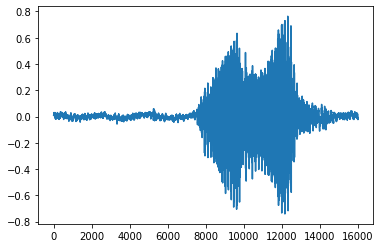

In [ ]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [ ]:
from tensorflow.keras.models import Sequential
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

melspecModel = Sequential()

melspecModel.add(Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )

melspecModel.add(Normalization2D(int_axis=0))

melspecModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mel_stft (Melspectrogram)   (None, 80, 125, 1)        1091664   
                                                                 
 normalization2d (Normalizat  (None, 80, 125, 1)       0         
 ion2D)                                                          
                                                                 
Total params: 1,091,664
Trainable params: 1,091,664
Non-trainable params: 0
_________________________________________________________________


In [ ]:
melspec = melspecModel.predict( audios.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

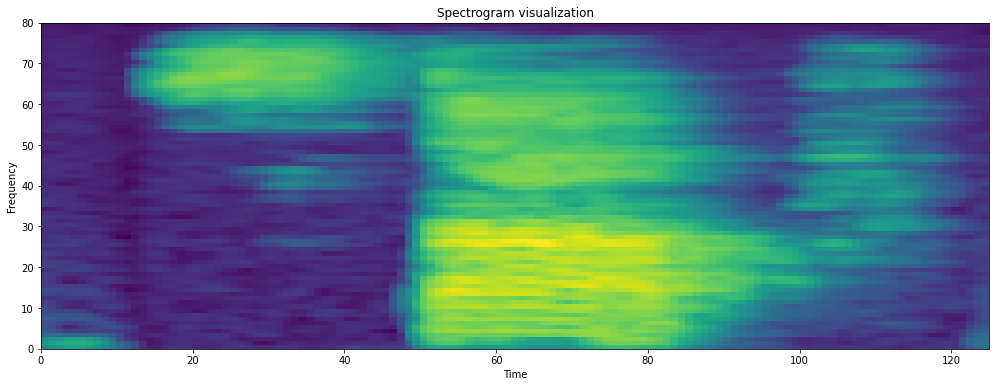

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(melspec[9,:,:,0])

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)

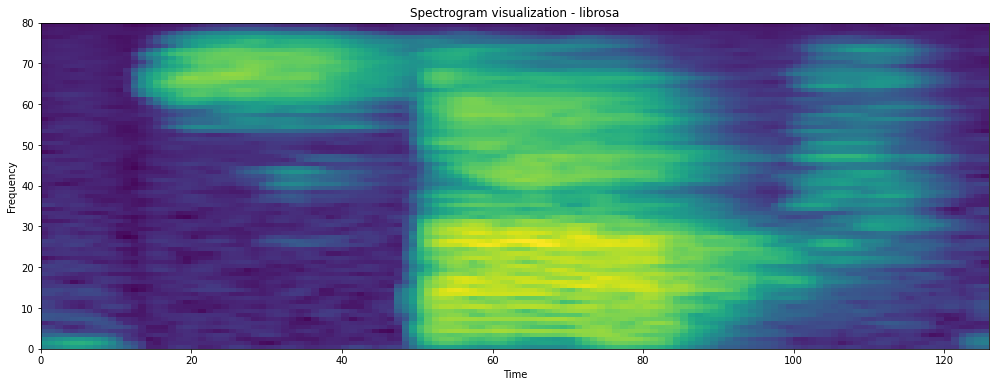

In [ ]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [ ]:
# plt.hist(melspec.flatten(), bins=100)

# Evaluate for Att-RNN

Create Keras models to see if the generators are working properly

In [ ]:
from tensorflow.keras.models import Model, load_model

from kapre.time_frequency import Melspectrogram, Spectrogram

In [ ]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

att_model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

att_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
att_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, None)      0           ['input[0][0]']                  
                                                                                                  
 mel_stft (Melspectrogram)      (None, 80, None, 1)  1091664     ['reshape[0][0]']                
                                                                                                  
 mel_stft_norm (Normalization2D  (None, 80, None, 1)  0          ['mel_stft[0][0]']               
 )                                                                                            

In [ ]:
att_model.load_weights('model-attRNN.h5')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
# valEval = att_model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
# trainEval = att_model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = att_model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics:{} \nTest: {}'.format(att_model.metrics_names, testEval) )

Evaluation scores: 
Metrics:['loss', 'sparse_categorical_accuracy'] 
Test: [0.25151124596595764, 0.9388459920883179]


In [ ]:
y_pred = att_model.predict(x_test, verbose=1)

344/344 [==============================] - 24s 66ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [ ]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


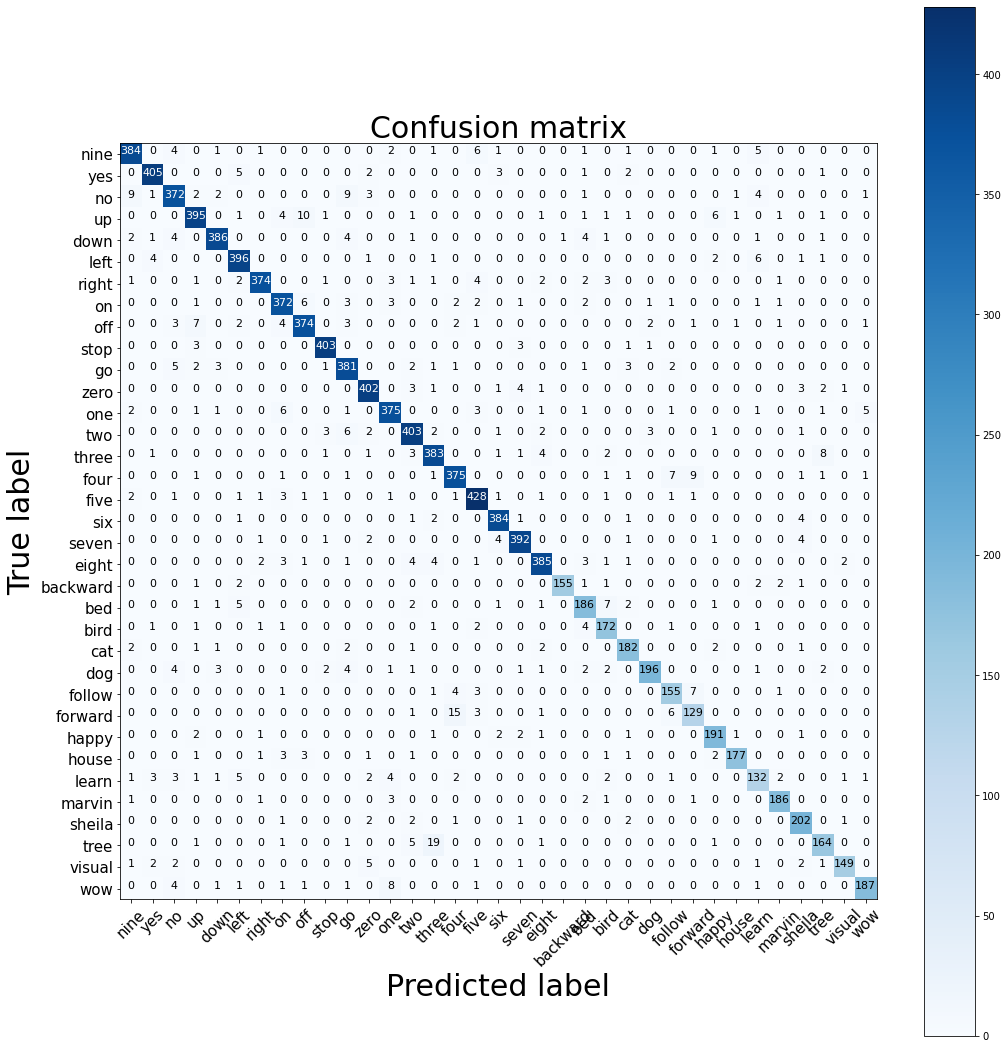

In [ ]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.7.0', '0.2.0', '1.1.5', '0.8.1']

### Evaluation Yochem

In [ ]:
y_pred = np.argmax(y_pred,1)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

y_true = y_test
commands = classes
print(f1_score(y_true, y_pred, average='weighted'))
print(precision_score(y_true, y_pred, average='weighted'))
print(recall_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred, target_names=commands))


data = classification_report(y_true, y_pred, target_names=commands, output_dict=True)

del data['weighted avg']
del data['macro avg']
del data['accuracy']

labels = data.keys()
vals = data.values()

prec = np.array([val['precision'] for val in data.values()])
reca = np.array([val['recall'] for val in data.values()])
f1sc = np.array([val['f1-score'] for val in data.values()])

print(prec.std(), reca.std(), f1sc.std())

0.9388126090079585
0.9391500822588478
0.9388459791004089
              precision    recall  f1-score   support

        nine       0.95      0.94      0.94       408
         yes       0.97      0.97      0.97       419
          no       0.93      0.92      0.92       405
          up       0.94      0.93      0.93       425
        down       0.96      0.95      0.96       406
        left       0.94      0.96      0.95       412
       right       0.98      0.94      0.96       396
          on       0.93      0.94      0.93       396
         off       0.94      0.93      0.94       402
        stop       0.97      0.98      0.98       411
          go       0.91      0.95      0.93       402
        zero       0.95      0.96      0.96       418
         one       0.94      0.94      0.94       399
         two       0.93      0.95      0.94       424
       three       0.91      0.95      0.93       405
        four       0.93      0.94      0.93       400
        five       0.94 

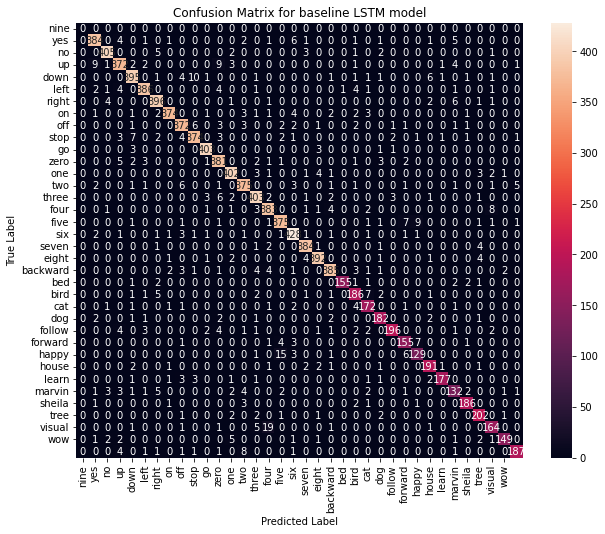

In [ ]:
import seaborn as sns
# Display a confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for baseline LSTM model')
plt.ylabel('True Label')
plt.show()

# Evaluate for RNN

In [ ]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

rnn_model = SpeechModels.RNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

rnn_model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
rnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 reshape_1 (Reshape)         (None, 1, None)           0         
                                                                 
 mel_stft (Melspectrogram)   (None, 80, None, 1)       1091664   
                                                                 
 normalization2d_1 (Normaliz  (None, 80, None, 1)      0         
 ation2D)                                                        
                                                                 
 permute_1 (Permute)         (None, None, 80, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, 80, 10)      60        
                                                           

In [ ]:
rnn_model.load_weights('model-RNN.h5')

In [ ]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [ ]:
# valEval = rnn_model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
# trainEval = rnn_model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = rnn_model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTest: {}'.format(rnn_model.metrics_names, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Test: [0.48280593752861023, 0.8633348345756531]


### Evaluation and Attention Plots

In [ ]:
y_pred = rnn_model.predict(x_test, verbose=1)

344/344 [==============================] - 22s 58ms/step


In [ ]:
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [ ]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [ ]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


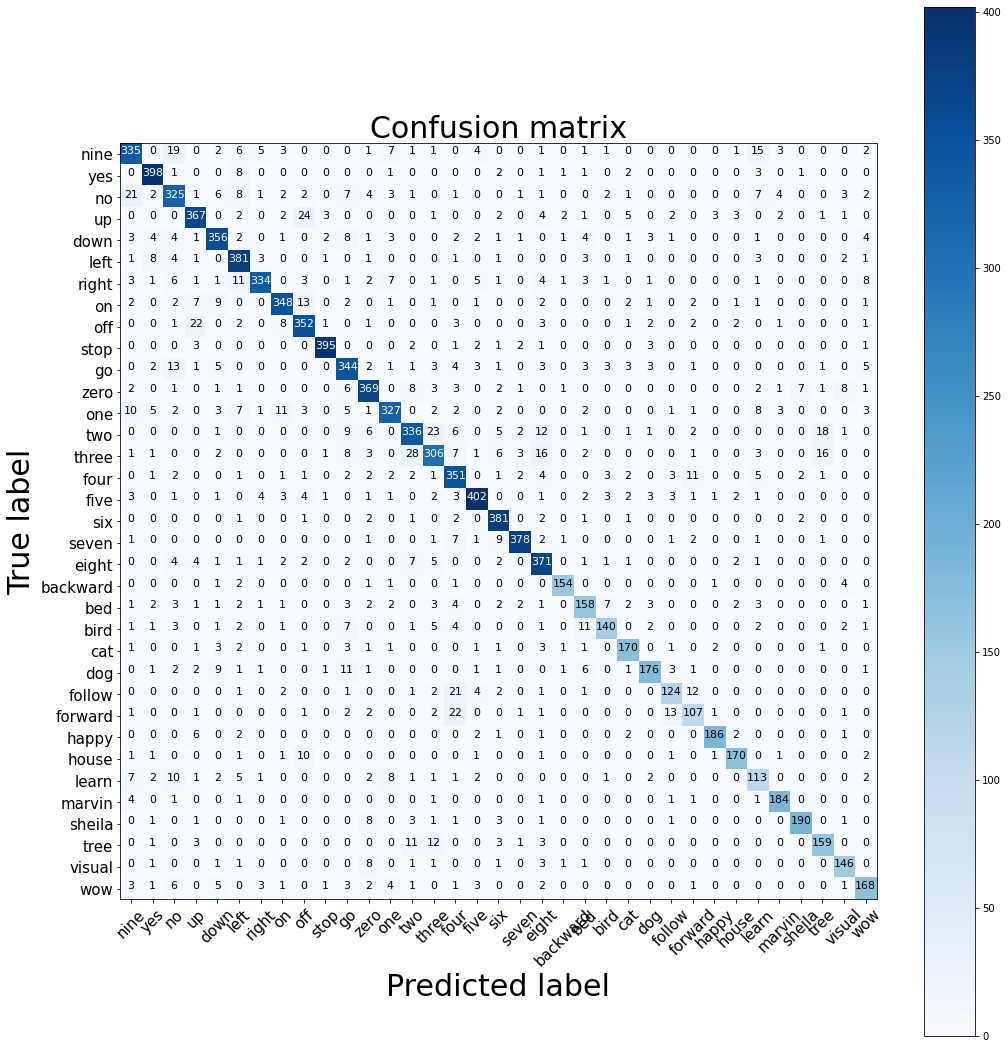

In [ ]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
import pandas as pd
import kapre
[tf.__version__, kapre.__version__, pd.__version__, librosa.__version__]

['2.7.0', '0.2.0', '1.1.5', '0.8.1']

### Evaluation Yochem

In [ ]:
y_pred = np.argmax(y_pred,1)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

y_true = y_test
commands = classes
print(f1_score(y_true, y_pred, average='weighted'))
print(precision_score(y_true, y_pred, average='weighted'))
print(recall_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred, target_names=commands))


data = classification_report(y_true, y_pred, target_names=commands, output_dict=True)

del data['weighted avg']
del data['macro avg']
del data['accuracy']

labels = data.keys()
vals = data.values()

prec = np.array([val['precision'] for val in data.values()])
reca = np.array([val['recall'] for val in data.values()])
f1sc = np.array([val['f1-score'] for val in data.values()])

print(prec.std(), reca.std(), f1sc.std())

0.8631379606649997
0.8644200511125903
0.8633348477964562
              precision    recall  f1-score   support

        nine       0.84      0.82      0.83       408
         yes       0.92      0.95      0.93       419
          no       0.79      0.80      0.80       405
          up       0.87      0.86      0.86       425
        down       0.87      0.88      0.87       406
        left       0.84      0.92      0.88       412
       right       0.94      0.84      0.89       396
          on       0.90      0.88      0.89       396
         off       0.84      0.88      0.86       402
        stop       0.97      0.96      0.97       411
          go       0.81      0.86      0.83       402
        zero       0.87      0.88      0.88       418
         one       0.89      0.82      0.85       399
         two       0.83      0.79      0.81       424
       three       0.81      0.76      0.78       405
        four       0.78      0.88      0.83       400
        five       0.92 

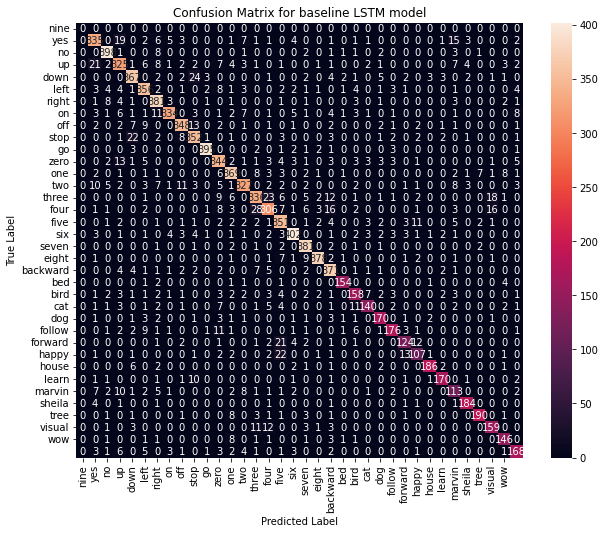

In [ ]:
import seaborn as sns
# Display a confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for baseline LSTM model')
plt.ylabel('True Label')
plt.show()